<a href="https://colab.research.google.com/github/orifelszer/CrimeData/blob/oriana-branch/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*In this notebook, we implement a Decision Tree Classifier to predict crime categories based on the provided features. We will handle data preprocessing, address class imbalance using SMOTE, and evaluate the model using various metrics such as accuracy and classification reports*



In [10]:
#!pip install imbalanced-learn
import pandas as pd
import zipfile
import requests
from io import BytesIO
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.exceptions import UndefinedMetricWarning
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)




We load the training and testing datasets directly from the GitHub repository. Each dataset is stored in a compressed `.zip` format and is extracted programmatically.

In [2]:
# Base URL for your GitHub repository
base_url = "https://github.com/orifelszer/CrimeData/raw/main/"

# File names
files = {
    "X_train": "X_train_supervised.zip",
    "X_test": "X_test_supervised.zip",
    "y_train": "y_train_supervised.zip",
    "y_test": "y_test_supervised.zip"
}



In [3]:
# Function to read zip files from the repository
def load_data_from_repo(file_name):
    url = base_url + file_name
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(BytesIO(response.content)) as z:
            # Assuming there's only one file in each zip
            extracted_file_name = z.namelist()[0]
            with z.open(extracted_file_name) as f:
                return pd.read_csv(f)
    else:
        raise Exception(f"Failed to download {file_name}")



In [4]:
# Load datasets
X_train = load_data_from_repo(files["X_train"])
X_test = load_data_from_repo(files["X_test"])
y_train = load_data_from_repo(files["y_train"]).values.ravel()
y_test = load_data_from_repo(files["y_test"]).values.ravel()




The target labels in the dataset are imbalanced, meaning some crime categories are significantly underrepresented. To address this issue, we use the **Synthetic Minority Oversampling Technique (SMOTE)**, which generates synthetic examples for minority classes to balance the dataset.


In [5]:
# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)



We implement a Decision Tree Classifier with the following parameters:
- `class_weight='balanced'`: Adjusts weights inversely proportional to class frequencies to handle imbalance.
- `random_state=42`: Ensures reproducibility of results.

Additionally, we prepare a basic model and provide a commented-out grid search implementation to explore hyperparameter optimization.

In [23]:
# Define the Decision Tree Classifier with class weights
base_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [24]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'max_depth': [10],
    'min_samples_split': [10],
    'min_samples_leaf': [5],
    'criterion': ['gini']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best Cross-Validation Score: 0.4137104895171644



The model performed better during cross-validation with an average accuracy 41.37% of , likely because it saw more balanced or familiar patterns from the training data.

In [25]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set using the best estimator from GridSearchCV
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate and print classification report
classification_report_output = classification_report(y_test, y_pred, zero_division=0)
print("\nClassification Report:\n", classification_report_output)


Accuracy: 35.97%

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       366
           1       0.46      0.10      0.16      7408
           2       0.00      0.00      0.00      3288
           3       0.16      0.00      0.01     23317
           4       0.37      0.61      0.46    126443
           5       0.18      0.10      0.13      6912
           6       0.00      0.00      0.00       126
           7       0.14      0.00      0.00     17566
           8       0.00      0.00      0.00       625
           9       0.19      0.03      0.05     59252
          10       0.36      0.43      0.39    128157
          11       0.00      0.00      0.00      1377
          12       0.00      0.00      0.00      2074
          13       0.00      0.00      0.00        60

    accuracy                           0.36    376971
   macro avg       0.13      0.09      0.09    376971
weighted avg       0.31      0.36     

This means the model correctly predicted 35.97% of samples in the test set.
The model performed worse on the test set, which indicates it struggles to generalize to unseen data.
The gap between cross-validation accuracy and test accuracy reflects the model's ability to generalize. A smaller gap indicates better generalization, while a larger gap suggests overfitting or challenges in adapting to new data.

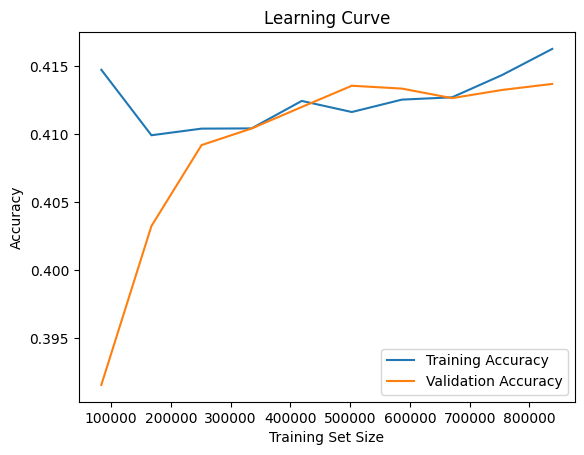

In [30]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train, cv=3, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()


The learning curve plots training accuracy and validation accuracy as the training set size increases.
Helps diagnose overfitting or underfitting.


Both training and validation accuracy are converging at 41%.
The model does not improve significantly with more data, indicating it may have reached its capacity or is limited by the features.
